# Spain Power Price Prediction

In this notebook we will be going through different steps we did for forecasting the Price of Power in Spain. It is structured as follows:

1. Load Data.
2. Data Preprocessing and Exploratory Data Analysis(EDA)
3. Feature Engineering
4. Feature Selection
5. Machine Learning (Modeling)
6. Prediction

In [1]:
# Load libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from astral import LocationInfo
from astral.sun import sun
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, RandomizedSearchCV


# setting global random seed.
np.random.seed(42)
random_state=42

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Load Data

We have 2 datasets:
* **power_market.csv**: This dataset is the one we will be using to train our model. We will also split this dataset for validation purpose.
* **scoring.csv**: In this dataset we have here different features that will be used to forecast the **Price** of power from **2020-09-01** to **2021-01-31**

In [3]:
train = pd.read_csv("power_market.csv")
test = pd.read_csv("scoring.csv")

In [4]:
train.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  price        date  hour  
0          5.1  58.82  2017-01-01     0  
1          0.6  58.23  2017-01-01     1  
2          4.6  51.95  2017-01-01     2  
3          9.7  47.27  2017-01-01     3  
4         24.1  45.49  2017-01-01     4

In [5]:
train.tail()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
32130    28832.0      7117.2     2200.0     1750.0   2846.0       2035.0   
32131    29453.0      7117.2     2200.0     1750.0   2861.0        325.8   
32132    30685.0      7117.2     2200.0     1750.0   2859.0          0.0   
32133    28699.0      7117.2     2200.0     1750.0   2771.0          0.0   
32134    26672.0      7117.2     2200.0     1750.0   2746.0          0.0   

       fc_solar_th  price        date  hour  
32130       1615.4  47.88  2020-08-31    19  
32131       1017.3  51.18  2020-08-31    20  
32132        682.5  55.69  2020-08-31    21  
32133        598.3  50.77  2020-08-31    22  
32134        617.8  45.00  2020-08-31    23

In [6]:
test.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24744.0      7117.2     2300.0     1750.0   2751.0          0.0   
1    23426.0      7117.2     2300.0     2100.0   2452.0          0.0   
2    22597.0      7117.2     2300.0     2100.0   2060.0          0.0   
3    22285.0      7117.2     2300.0     2100.0   1736.0          0.0   
4    22192.0      7117.2     2300.0     2100.0   1322.0          0.0   

   fc_solar_th        date  hour  
0        627.1  2020-09-01     0  
1        606.6  2020-09-01     1  
2        528.3  2020-09-01     2  
3        598.5  2020-09-01     3  
4        474.9  2020-09-01     4

In [7]:
test.tail()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
3668    28815.0      7117.2     2400.0     2200.0  15507.0          0.0   
3669    29927.0      7117.2     2400.0     2200.0  16146.0          0.0   
3670    29864.0      7117.2     2400.0     2200.0  16624.0          0.0   
3671    28494.0      7117.2     2400.0     2200.0  16599.0          0.0   
3672    25892.0      7117.2     2400.0     2200.0  15431.0          0.0   

      fc_solar_th        date  hour  
3668          6.1  2021-01-31    19  
3669          6.0  2021-01-31    20  
3670         11.1  2021-01-31    21  
3671          8.3  2021-01-31    22  
3672          1.2  2021-01-31    23

# 2. Data Preprocessing and EDA 

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fc_demand    32135 non-null  float64
 1   fc_nuclear   32135 non-null  float64
 2   import_FR    32122 non-null  float64
 3   export_FR    32122 non-null  float64
 4   fc_wind      32135 non-null  float64
 5   fc_solar_pv  32135 non-null  float64
 6   fc_solar_th  32135 non-null  float64
 7   price        32135 non-null  float64
 8   date         32135 non-null  object 
 9   hour         32135 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5+ MB


It looks like we have 9 columns in total with some missing data on **import and export** variables.

We have listed what each column value represents for as follows:

* **fc_demand** - forecast of demand in MWh
* **fc_nuclear** - forecast of nuclear power production in MWh
* **import_FR** -forecast of the importing capacity from France to Spain in MWh 
* **export_FR** - forecast of the exporting capacity from Spain to France in MWh
* **fc_wind** - forecast of wind power production in MWh
* **fc_solar_pv** - forecast pf PV solar (solar panels) power production in MWh 
* **fc_solar_th** - forecast of thermal solar power production in MWh
* **price** - power price for each hour in €/MWh
* **date** - date of the obervation "Y-m-d"
* **hour** - hour of the observation, [0-23]

Our target variable is the **Price**. We also have a `date`  but with `str` type. We will be extracting some information from this later and see if we can find any relation with our target variable. Let's take care of our `date` variable first.

In [9]:
train["date"] = pd.to_datetime(train["date"], infer_datetime_format=True)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fc_demand    32135 non-null  float64       
 1   fc_nuclear   32135 non-null  float64       
 2   import_FR    32122 non-null  float64       
 3   export_FR    32122 non-null  float64       
 4   fc_wind      32135 non-null  float64       
 5   fc_solar_pv  32135 non-null  float64       
 6   fc_solar_th  32135 non-null  float64       
 7   price        32135 non-null  float64       
 8   date         32135 non-null  datetime64[ns]
 9   hour         32135 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 2.5 MB


In [11]:
print("Our train data shape is {}".format(train.shape))

Our train data shape is (32135, 10)


In [12]:
# Extracting date related information from date column
train["day"] = train["date"].dt.day
train["month"] = train["date"].dt.month
train["year"] = train["date"].dt.year
train["quarter"] = train["date"].dt.quarter
train["weekday"] = train["date"].dt.weekday
train["season"] = (train["date"].dt.month%12 + 3)//3
train["weekend"] = list(map(lambda x: 1 if x > 4 else 0, train["weekday"]))

In [13]:
train.head()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
0    24400.0      7117.2     3000.0     2600.0   1732.0          0.0   
1    23616.0      7117.2     3000.0     2650.0   1826.0          0.0   
2    21893.0      7117.2     3000.0     2650.0   1823.0          0.0   
3    20693.0      7117.2     3000.0     2650.0   1777.0          0.0   
4    19599.0      7117.2     3000.0     2650.0   1746.0          0.0   

   fc_solar_th  price       date  hour  day  month  year  quarter  weekday  \
0          5.1  58.82 2017-01-01     0    1      1  2017        1        6   
1          0.6  58.23 2017-01-01     1    1      1  2017        1        6   
2          4.6  51.95 2017-01-01     2    1      1  2017        1        6   
3          9.7  47.27 2017-01-01     3    1      1  2017        1        6   
4         24.1  45.49 2017-01-01     4    1      1  2017        1        6   

   season  weekend  
0       1        1  
1       1        1  
2       1        1  
3       1        1  
4       1        1

In [14]:
train.tail()

fc_demand  fc_nuclear  import_FR  export_FR  fc_wind  fc_solar_pv  \
32130    28832.0      7117.2     2200.0     1750.0   2846.0       2035.0   
32131    29453.0      7117.2     2200.0     1750.0   2861.0        325.8   
32132    30685.0      7117.2     2200.0     1750.0   2859.0          0.0   
32133    28699.0      7117.2     2200.0     1750.0   2771.0          0.0   
32134    26672.0      7117.2     2200.0     1750.0   2746.0          0.0   

       fc_solar_th  price       date  hour  day  month  year  quarter  \
32130       1615.4  47.88 2020-08-31    19   31      8  2020        3   
32131       1017.3  51.18 2020-08-31    20   31      8  2020        3   
32132        682.5  55.69 2020-08-31    21   31      8  2020        3   
32133        598.3  50.77 2020-08-31    22   31      8  2020        3   
32134        617.8  45.00 2020-08-31    23   31      8  2020        3   

       weekday  season  weekend  
32130        0       3        0  
32131        0       3        0  
32132        0       3        0  
32133        0       3        0  
32134        0       3        0

In [15]:
# Checking if our date is in the right time order.
train["date"].is_monotonic

True

In [16]:
# How many years of data we have
train["year"].value_counts()

2017    8760
2018    8760
2019    8760
2020    5855
Name: year, dtype: int64

From the above we can see that we have 4 years worth of data and our data is ordered monotonically in time.

In [17]:
# statistical summary of our data
train.describe()

fc_demand    fc_nuclear     import_FR     export_FR       fc_wind  \
count  32135.000000  32135.000000  32122.000000  32122.000000  32135.000000   
mean   28475.593527   6421.333431   2445.285163   2217.864703   5627.214688   
std     4686.675600    862.355391    623.215136    550.563300   3266.961919   
min    16372.000000   3672.800000    700.000000    200.000000    139.000000   
25%    24605.500000   6071.900000   2100.000000   1900.000000   3083.000000   
50%    28446.000000   7117.200000   2450.000000   2200.000000   4989.000000   
75%    32124.000000   7117.200000   2900.000000   2600.000000   7610.500000   
max    41103.000000   7117.200000   3700.000000   3700.000000  17232.000000   

        fc_solar_pv   fc_solar_th         price          hour           day  \
count  32135.000000  32135.000000  32135.000000  32135.000000  32135.000000   
mean    1100.253546    601.186600     48.440119     11.500296     15.727058   
std     1512.531532    681.584906     14.842233      6.922199      8.799477   
min        0.000000      0.000000      0.030000      0.000000      1.000000   
25%        0.000000     31.600000     39.770000      6.000000      8.000000   
50%      107.800000    331.400000     49.880000     12.000000     16.000000   
75%     2099.350000    957.150000     58.250000     17.500000     23.000000   
max     7211.200000   2253.700000    101.990000     23.000000     31.000000   

              month          year       quarter       weekday        season  \
count  32135.000000  32135.000000  32135.000000  32135.000000  32135.000000   
mean       6.160573   2018.364400      2.395394      2.999907      2.436347   
std        3.359349      1.068292      1.091109      2.001859      1.070921   
min        1.000000   2017.000000      1.000000      0.000000      1.000000   
25%        3.000000   2017.000000      1.000000      1.000000      2.000000   
50%        6.000000   2018.000000      2.000000      3.000000      2.000000   
75%        9.000000   2019.000000      3.000000      5.000000      3.000000   
max       12.000000   2020.000000      4.000000      6.000000      4.000000   

            weekend  
count  32135.000000  
mean       0.286012  
std        0.451902  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

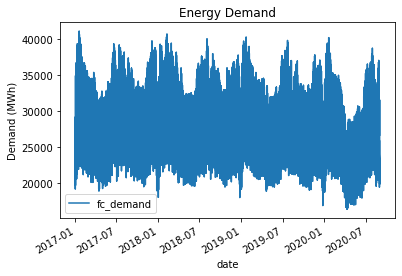

In [18]:
# Demand through 2017 to 2020
train.plot(x = "date", y = "fc_demand", title="Energy Demand")
plt.ylabel("Demand (MWh)")
plt.show()

From the plot above our energy demand shows some seasonal characterstics.

Let's have a deeper look by ploting our **price** and **demand**

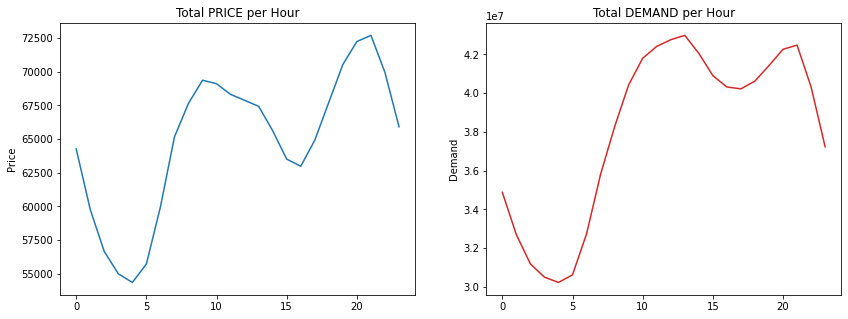

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train.groupby("hour")["price"].sum())
axes[0].set_ylabel("Price")
axes[0].set_title("Total PRICE per Hour")
axes[1].plot(train.groupby("hour")["fc_demand"].sum(), 'tab:red')
axes[1].set_ylabel("Demand")
axes[1].set_title("Total DEMAND per Hour");

Interestingly our **Price** and **Demand** show similar pattern throughout the day. We have demand increase during the morning and goes down close to midnight. Price also show the same pattern.

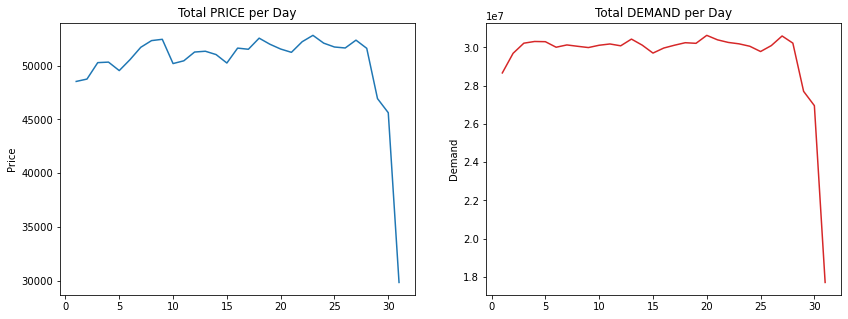

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train.groupby("day")["price"].sum())
axes[0].set_ylabel("Price")
axes[0].set_title("Total PRICE per Day")
axes[1].plot(train.groupby("day")["fc_demand"].sum(), 'tab:red')
axes[1].set_ylabel("Demand")
axes[1].set_title("Total DEMAND per Day");

This plot shows the **daily** values of **Price** and **Demand**. It's pretty much the same and we see a certain drop during the end of the months. This might be related to the fact that we have a some months with **31** days.

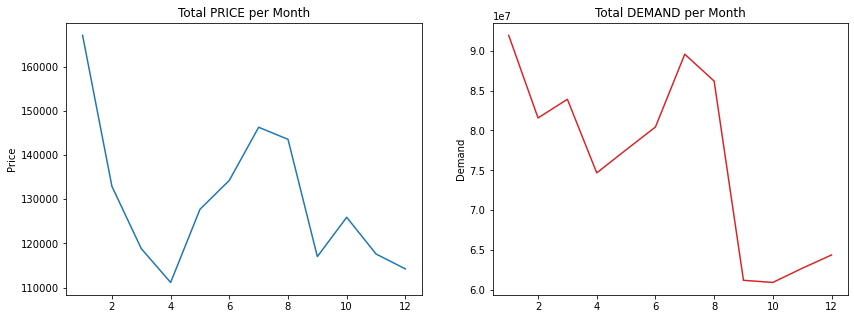

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train.groupby("month")["price"].sum())
axes[0].set_ylabel("Price")
axes[0].set_title("Total PRICE per Month")
axes[1].plot(train.groupby("month")["fc_demand"].sum(), 'tab:red')
axes[1].set_ylabel("Demand")
axes[1].set_title("Total DEMAND per Month");

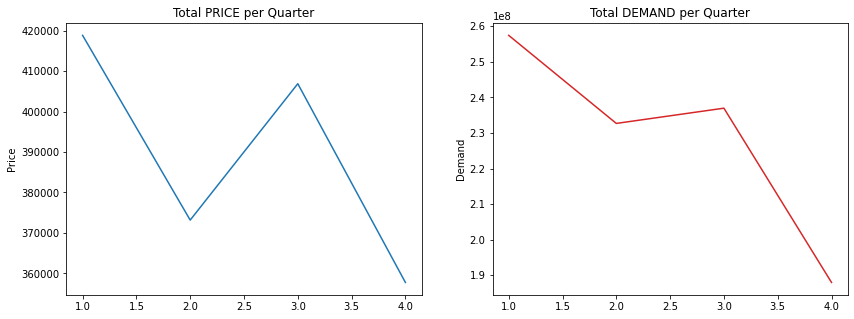

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train.groupby("quarter")["price"].sum())
axes[0].set_ylabel("Price")
axes[0].set_title("Total PRICE per Quarter")
axes[1].plot(train.groupby("quarter")["fc_demand"].sum(), 'tab:red')
axes[1].set_ylabel("Demand")
axes[1].set_title("Total DEMAND per Quarter");

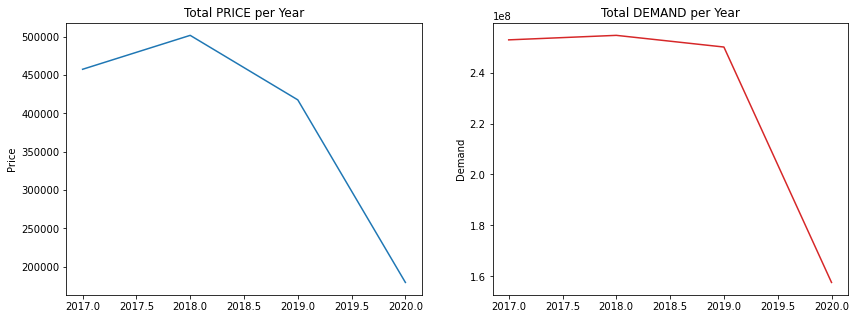

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train.groupby("year")["price"].sum())
axes[0].set_ylabel("Price")
axes[0].set_title("Total PRICE per Year")
axes[1].plot(train.groupby("year")["fc_demand"].sum(), 'tab:red')
axes[1].set_ylabel("Demand")
axes[1].set_title("Total DEMAND per Year");

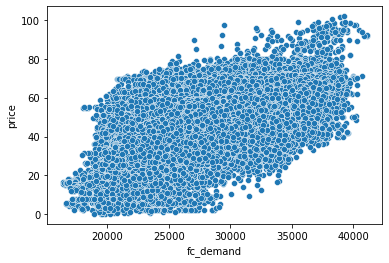

In [24]:
sns.scatterplot(data=train, x="fc_demand", y="price")
plt.show()

We we look at **Price** Vs **Demand** they show some kind of linear relationship. As Demand increases, Price also increases.

## Distribution Plots.

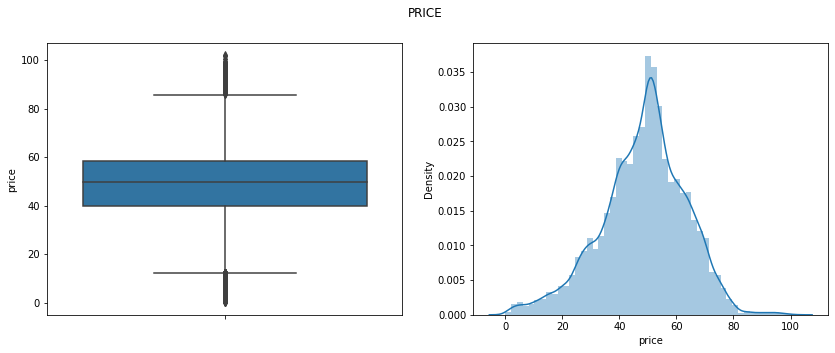

In [27]:
fig, ax =plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=train, y="price", ax=ax[0])
sns.distplot(train["price"], ax=ax[1])
fig.show()
fig.suptitle('PRICE');

Our price is normally distributed. From the box plots we can see that there are some outliers. We will see later on if this outliers are anomalies or data collection errors.

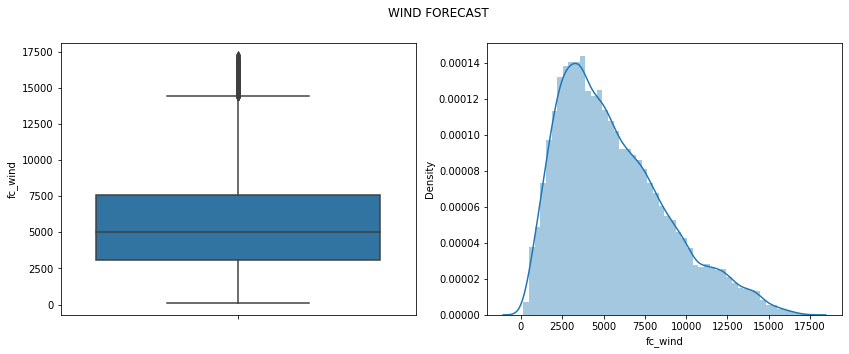

In [28]:
fig, ax =plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=train, y="fc_wind", ax=ax[0])
sns.distplot(train["fc_wind"], ax=ax[1])
fig.show()
fig.suptitle('WIND FORECAST');

On the other hand the **Wind** forecast seem skewed to the right (Positive skewness). This means most of the wind power forecast lies in the range **2500 - 5000**

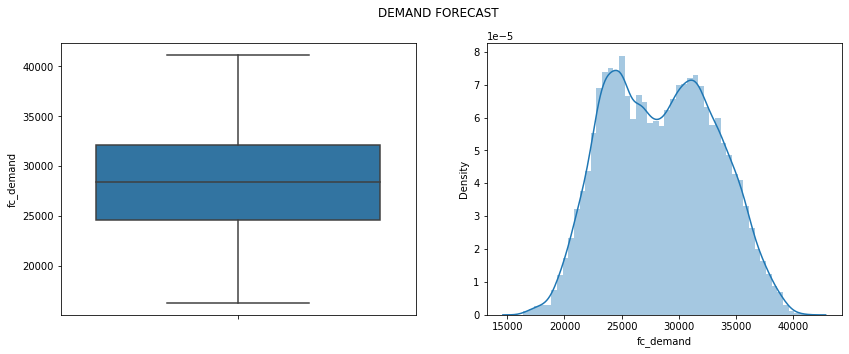

In [29]:
fig, ax =plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=train, y="fc_demand", ax=ax[0])
sns.distplot(train["fc_demand"], ax=ax[1])
fig.show()
fig.suptitle('DEMAND FORECAST');

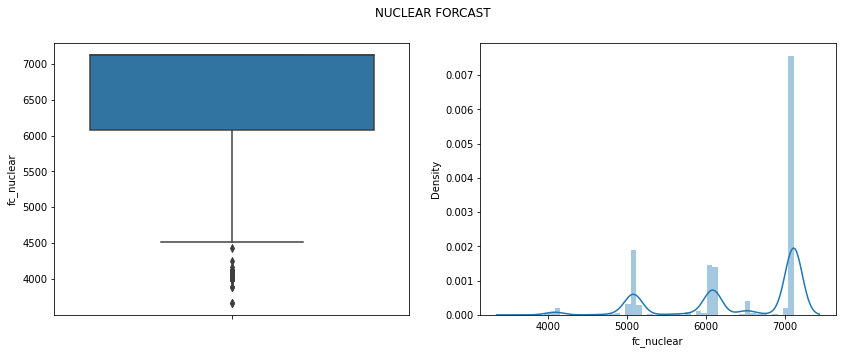

In [30]:
fig, ax =plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=train, y="fc_nuclear", ax=ax[0])
sns.distplot(train["fc_nuclear"], ax=ax[1])
fig.show()
fig.suptitle('NUCLEAR FORCAST');

The Nuclear energy forecast clearly shows us we have higher values at certain points. This might be due to the fact that Nulcear plants are run for only certain times and thier production is relates with the amount of time the reactors operate.

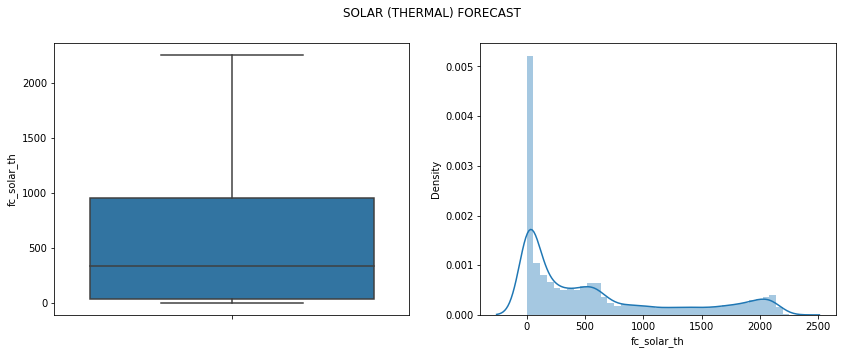

In [31]:
fig, ax =plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=train, y="fc_solar_th", ax=ax[0])
sns.distplot(train["fc_solar_th"], ax=ax[1])
fig.show()
fig.suptitle('SOLAR (THERMAL) FORECAST');

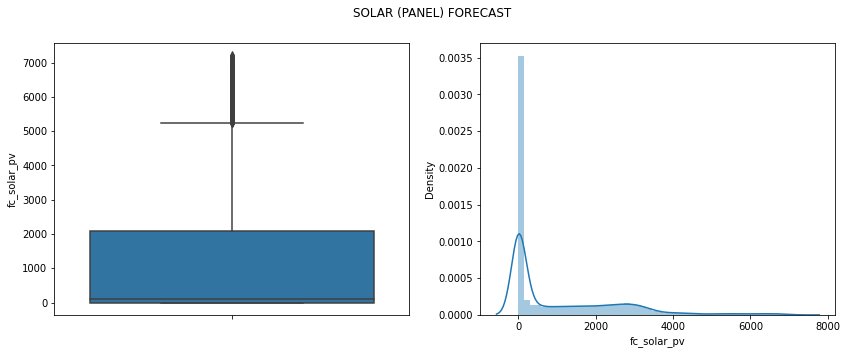

In [32]:
fig, ax =plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=train, y="fc_solar_pv", ax=ax[0])
sns.distplot(train["fc_solar_pv"], ax=ax[1])
fig.show()
fig.suptitle('SOLAR (PANEL) FORECAST');

Looking at the above two plots for **solar thermal power** and **solar energy** we can see that we have lower power forecast compared to other renewable sources. The core difference between **solar PV** and **solar thermal** can be found in their working principles. **Solar PV** is based on the photovoltaic effect, by which a photon (the basic unit of light) impacting a surface made of a special material generates the release of an electron. **Solar thermal**, on the other hand, uses sunlight to heat a fluid (depending on the particular application, it can be water or other fluid). 

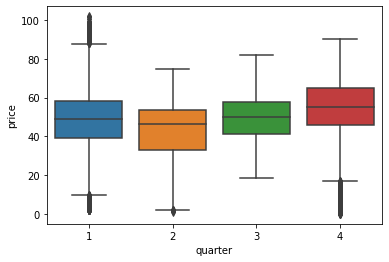

In [33]:
sns.boxplot(data=train, x="quarter", y="price")
plt.show()

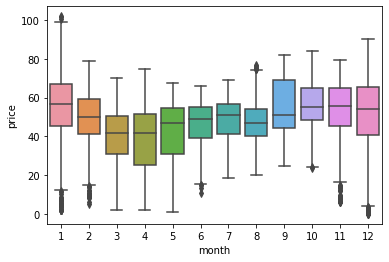

In [34]:
sns.boxplot(data=train, x="month",y="price")
plt.show()

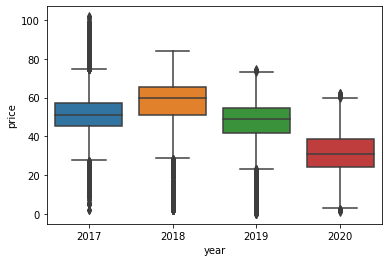

In [35]:
sns.boxplot(data=train, x="year", y="price")
plt.show()

## Pair Plots

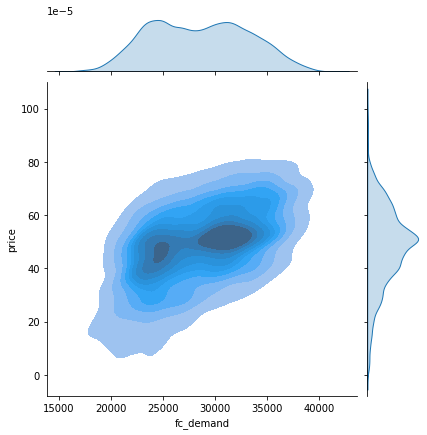

In [36]:
sns.jointplot(data=train, x="fc_demand", y="price", kind="kde", fill=True)
plt.show()

Our prices and demands are more concentrated around 40-60 Euros and 30000(MWh) respectively.

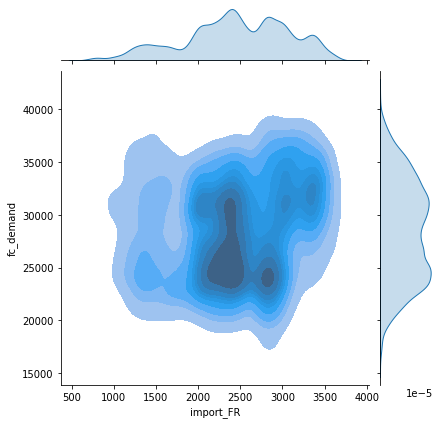

In [37]:
sns.jointplot(data=train, x="import_FR", y="fc_demand", kind="kde", fill=True)
plt.show()

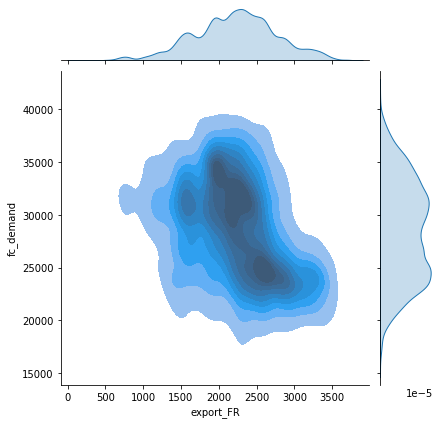

In [38]:
sns.jointplot(data=train, x="export_FR", y="fc_demand", kind="kde", fill=True)
plt.show()

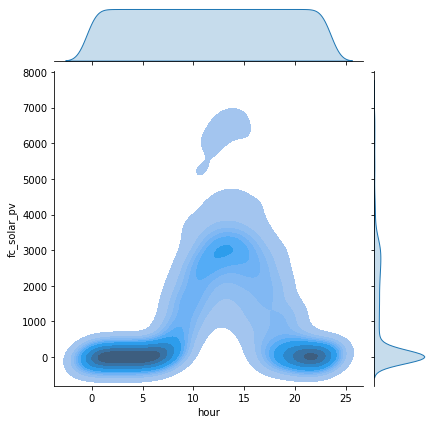

In [39]:
sns.jointplot(data=train, x="hour", y="fc_solar_pv", kind='kde', fill=True)

This clearly shows us production of solar power depends on the hour. We have less to no production during night times. Mean while we can see more forecases during the daylight.

## Overall relationship between variables.

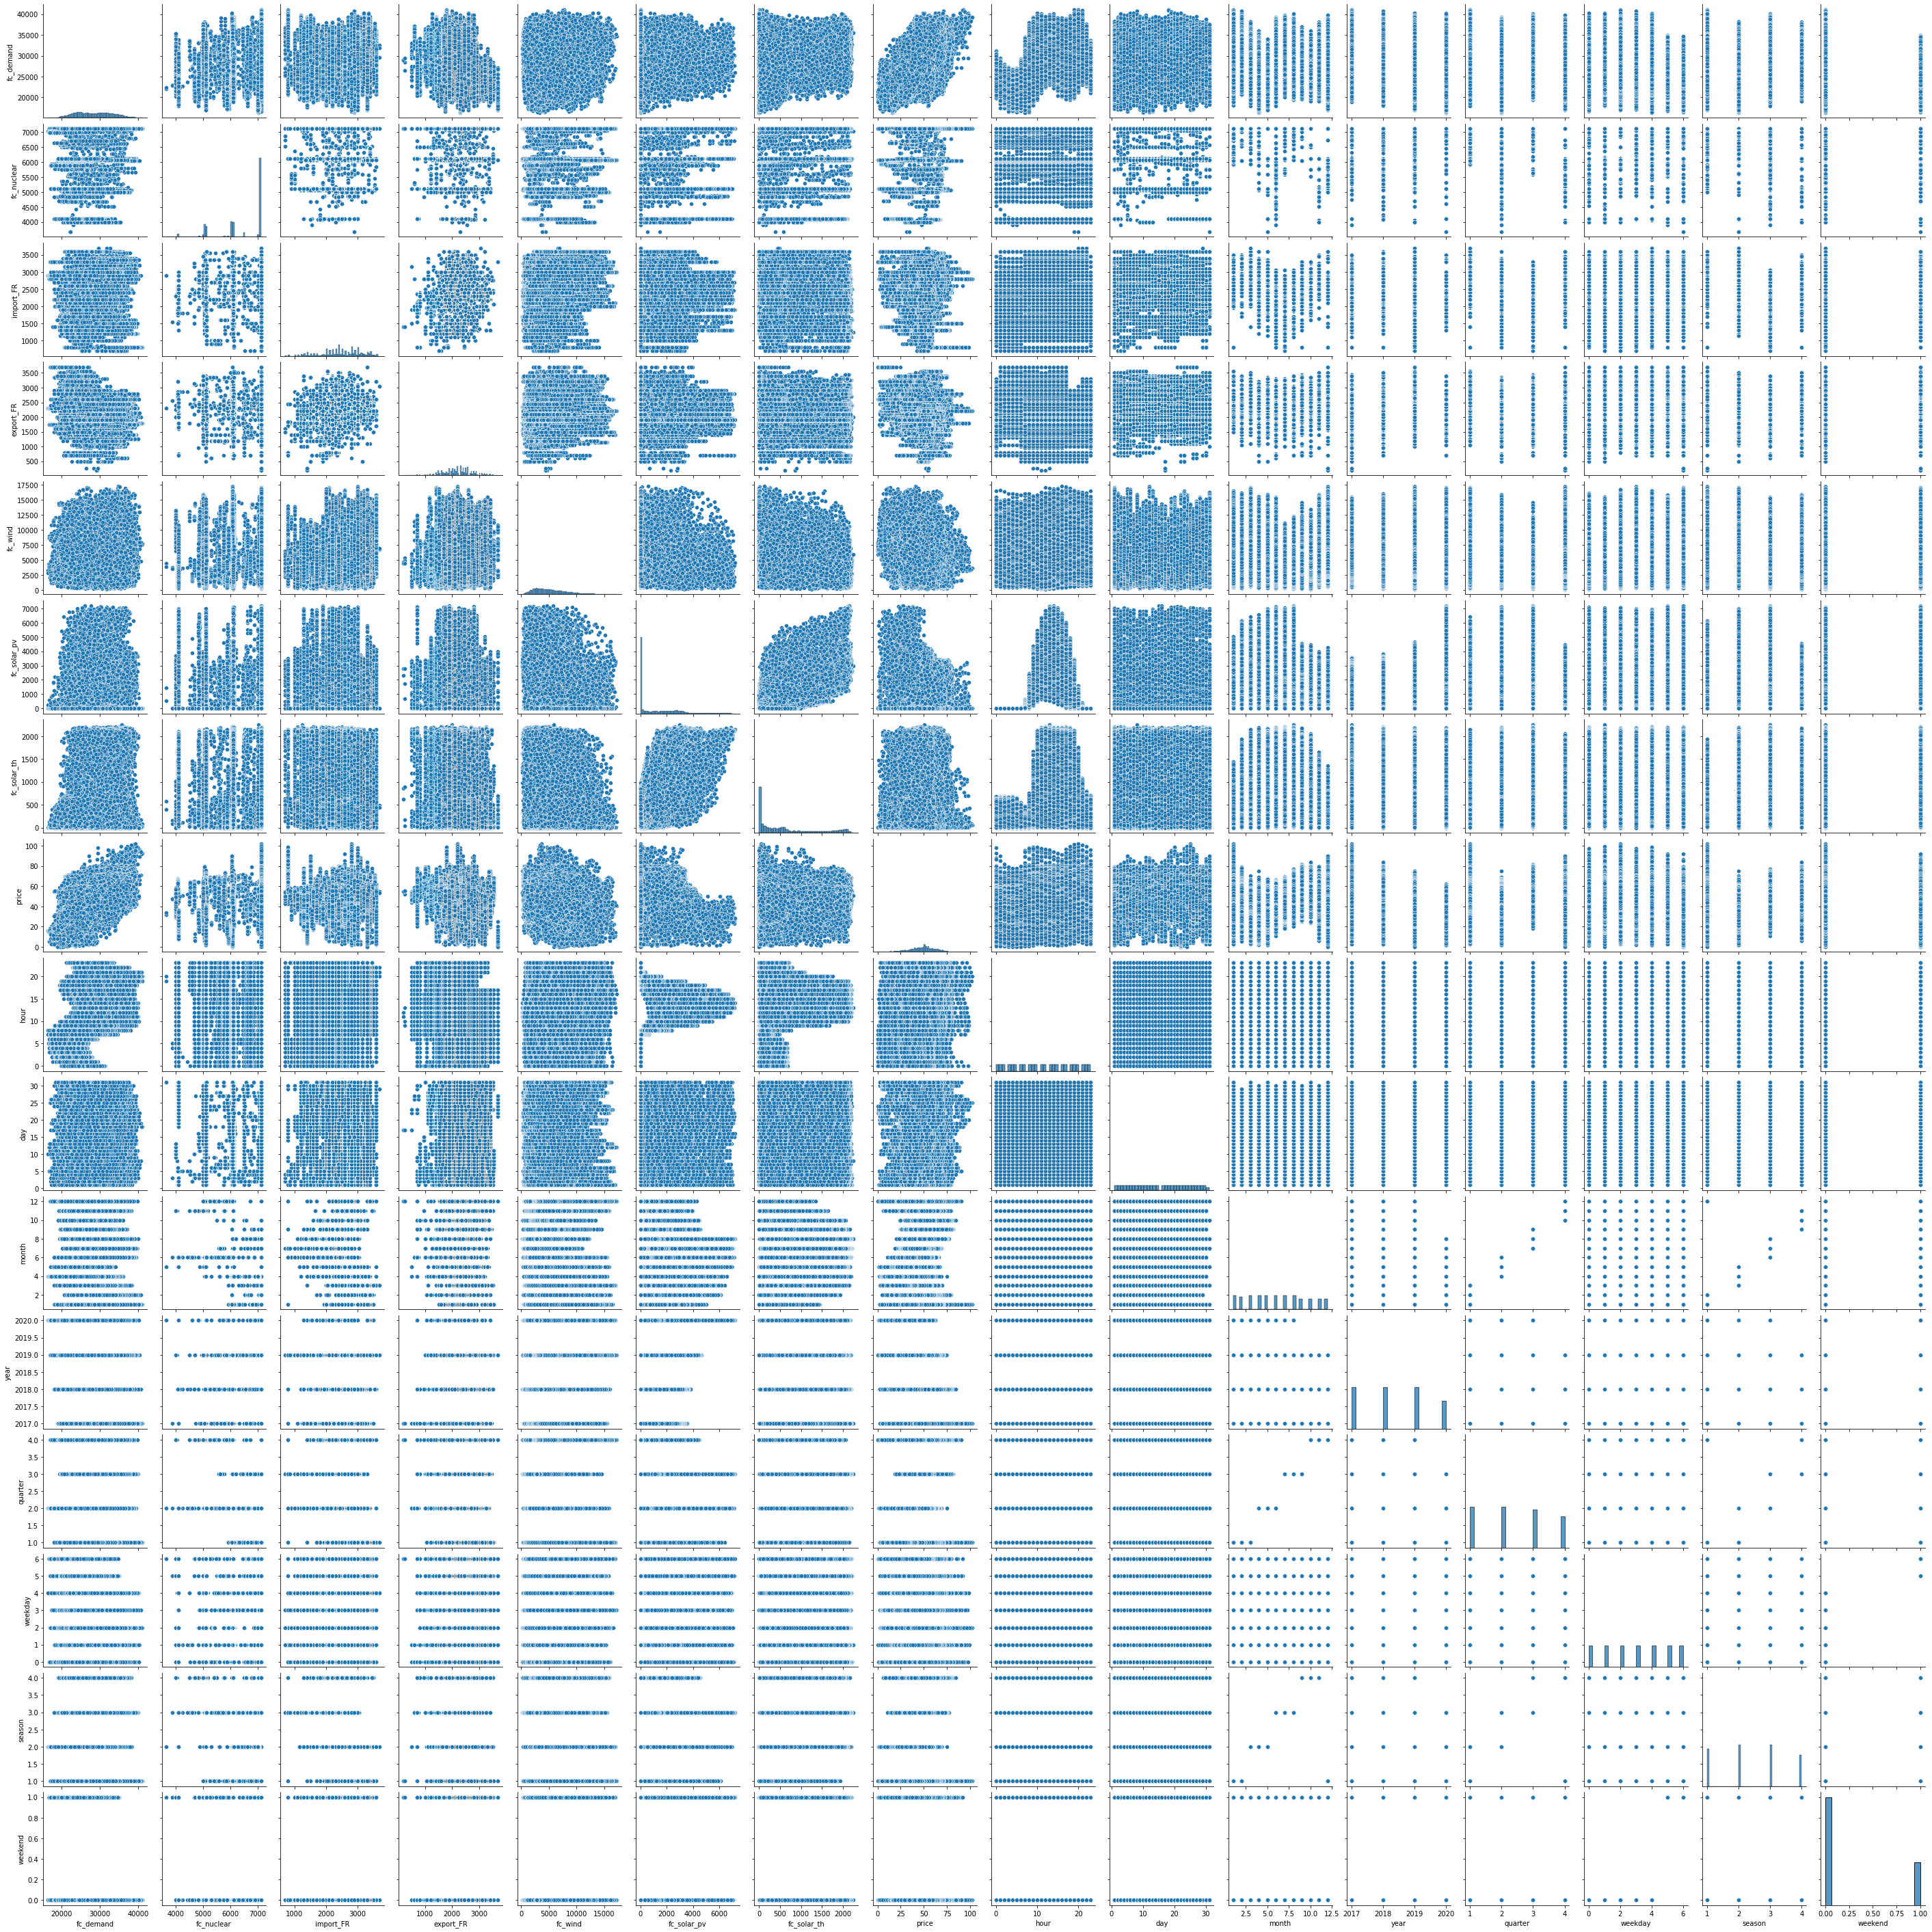

In [40]:
sns.pairplot(train)
plt.show()

In [41]:
corr_matrix = train.drop(columns=["date"]).corr()

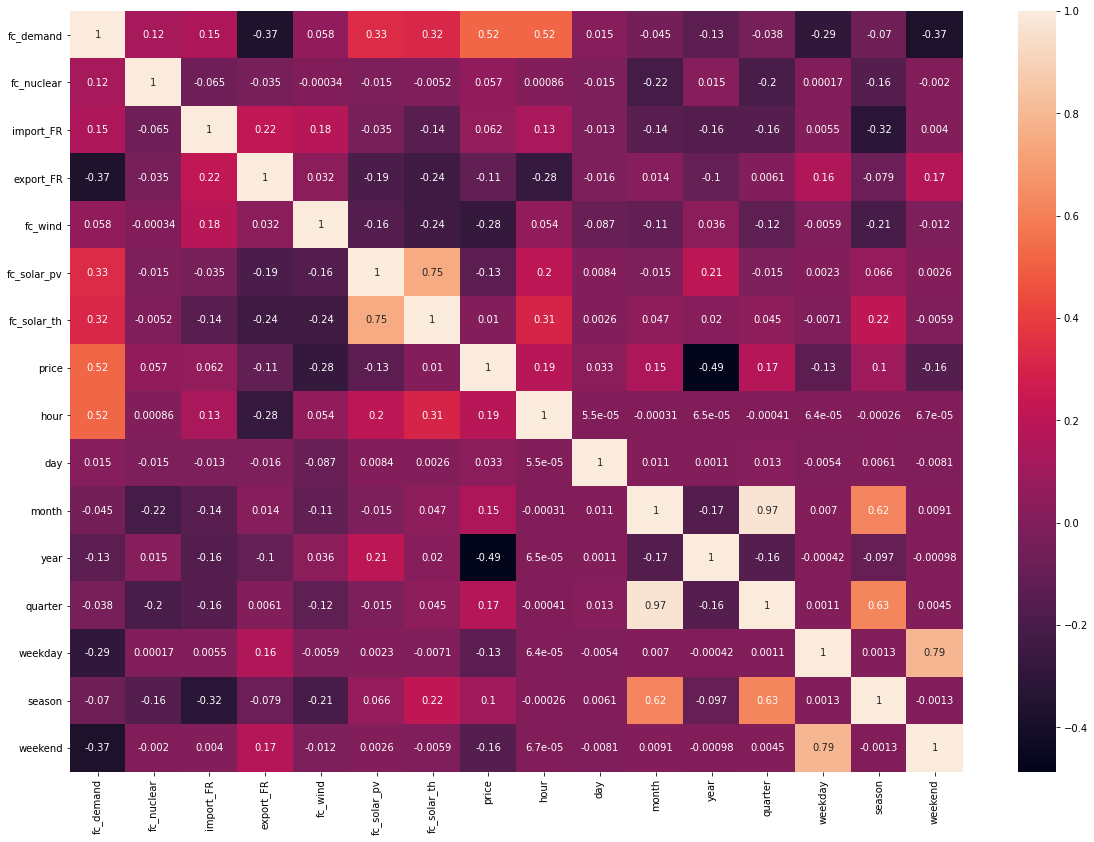

In [42]:
sns.heatmap(corr_matrix, annot=True) 
fig=plt.gcf()
fig.set_size_inches(20,14)
plt.show()

## Build a simple model

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

### Missing Variables

In [26]:
train.isna().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
day             0
month           0
year            0
quarter         0
weekday         0
season          0
weekend         0
dtype: int64

Looks like we only have two missing variables. Since this is time series data, we will be using **forward fill** to impute the missing values.

In [27]:
train["import_FR"].fillna(method="ffill", inplace=True)
train["export_FR"].fillna(method="ffill", inplace=True)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fc_demand    32135 non-null  float64       
 1   fc_nuclear   32135 non-null  float64       
 2   import_FR    32135 non-null  float64       
 3   export_FR    32135 non-null  float64       
 4   fc_wind      32135 non-null  float64       
 5   fc_solar_pv  32135 non-null  float64       
 6   fc_solar_th  32135 non-null  float64       
 7   price        32135 non-null  float64       
 8   date         32135 non-null  datetime64[ns]
 9   hour         32135 non-null  int64         
 10  day          32135 non-null  int64         
 11  month        32135 non-null  int64         
 12  year         32135 non-null  int64         
 13  quarter      32135 non-null  int64         
 14  weekday      32135 non-null  int64         
 15  season       32135 non-null  int64         
 16  week

In [29]:
train["date"].apply(["min", "max"])

min   2017-01-01
max   2020-08-31
Name: date, dtype: datetime64[ns]

In [30]:
test["date"].apply(["min", "max"])

min    2020-09-01
max    2021-01-31
Name: date, dtype: object

In the training dataset, we have three years and 8 month worth of data. We will be predicting for 5 months in the future. So let's split the training dataset for validation with similar size as our test data. 

In [31]:
def train_test_split(data, date_split):

    # training vs target
    x = data.drop(columns=["price"])
    y = data[["date", "price"]]

    # splitting data
    x_train = x[x["date"] < date_split].drop("date", axis=1)
    x_test = x[x["date"] >= date_split].drop("date", axis=1)
    y_train = y[y["date"] < date_split].drop("date", axis=1).values.ravel()
    y_test = y[y["date"] >= date_split].drop("date", axis=1).values.ravel()

    print(f"x_train: {x_train.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    return x_train, x_test, y_train, y_test

# split time
date_split = pd.to_datetime("2020-05-01")

In [32]:
# train and evaluate model
# outputs the rmse results.
def train_models(data, split_time):
    
    X_train, X_test, y_train, y_test = train_test_split(data, split_time)
    
    # instantiate models
    linear_model = LinearRegression()
    lasso_model = Lasso()
    ridge_model = Ridge()
    elastic_model = ElasticNet()
    tree_model = DecisionTreeRegressor()
    
    # fit models
    linear_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)
    ridge_model.fit(X_train, y_train)
    elastic_model.fit(X_train, y_train)
    tree_model.fit(X_train, y_train)
    
    # predict
    lin_reg_pred = linear_model.predict(X_test)
    lasso_pred = lasso_model.predict(X_test)
    ridge_pred = ridge_model.predict(X_test)
    elastic_pred = elastic_model.predict(X_test)
    tree_pred = tree_model.predict(X_test)
    
    # evaluate
    lin_reg_rmse = rmse(y_test, lin_reg_pred)
    lasso_rmse = rmse(y_test, lasso_pred)
    ridge_rmse = rmse(y_test, ridge_pred)
    elastic_rmse = rmse(y_test, elastic_pred)
    tree_rmse = rmse(y_test, tree_pred)
    
    print("============== Linear Regression ==================")
    print("Root Mean Squared Error: {}".format(lin_reg_rmse))
    print("=============== Lasso ==================")
    print("Root Mean Squared Error: {}".format(lasso_rmse))
    print("=============== Ridge ==================")
    print("Root Mean Squared Error: {}".format(ridge_rmse))
    print("=============== Elastic ==================")
    print("Root Mean Squared Error: {}".format(elastic_rmse))
    print("=============== Decision Tree ==================")
    print("Root Mean Squared Error: {}".format(tree_rmse))

In [33]:
train_models(train, date_split)

x_train: (29183, 15)
x_test: (2952, 15)
y_train: (29183,)
y_test: (2952,)
============== Linear Regression ==================
Root Mean Squared Error: 7.994004969219727
=============== Lasso ==================
Root Mean Squared Error: 9.598465590578655
=============== Ridge ==================
Root Mean Squared Error: 7.994093802119976
=============== Elastic ==================
Root Mean Squared Error: 10.254310240250705
=============== Decision Tree ==================
Root Mean Squared Error: 16.587522024826953


We have **Linear Regression** and **Ridge** with better scores among others. We will take this as our baseline and move forward to find better models that will outperform this scores. 

### Outlier Analysis

As seen in the boxplots above, for example **price**, we can clearly see that there are some outlier at both ends. Usually removing the outliers seems to be the straightforward task to do. But since this is time series data, we can't afford to remove them. The optimal way to do is replace those outlier with **NA** and then **interpolate** to fill the values.

In [34]:
def get_outliers(data, col_name):
    q1 = data[col_name].quantile(0.25) 
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    outliers = data.loc[(data[col_name] > fence_low) & (data[col_name] < fence_high)]
    data.loc[data[col_name] < fence_low, col_name] = np.nan 
    data.loc[data[col_name] > fence_high, col_name] = np.nan
    print("{} outliers detected".format(len(data)-len(outliers)))

In [35]:
columns = ["fc_demand", "fc_nuclear", "import_FR", "export_FR", "fc_wind", "fc_solar_pv", "fc_solar_th", "price"]

In [36]:
for i, feature in enumerate(columns):
    print(f"Analyzing outliers of column: {feature}")
    get_outliers(train, feature)

Analyzing outliers of column: fc_demand
0 outliers detected
Analyzing outliers of column: fc_nuclear
728 outliers detected
Analyzing outliers of column: import_FR
294 outliers detected
Analyzing outliers of column: export_FR
539 outliers detected
Analyzing outliers of column: fc_wind
347 outliers detected
Analyzing outliers of column: fc_solar_pv
842 outliers detected
Analyzing outliers of column: fc_solar_th
0 outliers detected
Analyzing outliers of column: price
690 outliers detected


In [37]:
train.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [38]:
train_models(train, date_split)

x_train: (29183, 15)
x_test: (2952, 15)
y_train: (29183,)
y_test: (2952,)
============== Linear Regression ==================
Root Mean Squared Error: 8.973018371102352
=============== Lasso ==================
Root Mean Squared Error: 10.767435562032942
=============== Ridge ==================
Root Mean Squared Error: 8.973139597092839
=============== Elastic ==================
Root Mean Squared Error: 11.349397595857797
=============== Decision Tree ==================
Root Mean Squared Error: 14.114128783720716


Nice to see we have some improvement on **Lasso** and **Decision Tree**. It's good that we see some improvement on our baseline.

# 3. Feature Engineering.

Since we will be using this feature engineering for the test data, we decided to create a pipeline including the ones we did before.

In [39]:
def extract_date_features(series):
    df = pd.DataFrame({"year": series.dt.year,
                       "month": series.dt.month,
                       "weekday": series.dt.weekday,
                       "day": series.dt.day,
                       "quarter": series.dt.quarter,
                       "season": (series.dt.month%12 + 3)//3})
    return df

In [40]:
def extract_weekend(series):
    weekend = list(map(lambda x: 1 if x>4 else 0, series.dt.weekday))
    
    return pd.DataFrame({"weekend": weekend})

In [41]:
def get_loc_info(location="Spain"):
    # get latitude and longitude
    geolocator = Nominatim(user_agent="pythonGA") # here user_agent is to limit the number of requ
    location = geolocator.geocode(location)
    
    # find the time zone from location
    obj = TimezoneFinder() 
    timezone = obj.timezone_at(lng=location.longitude, lat=location.latitude)
    
    # get sun movment from location and time zone.
    # Location Info takes 5 arguments.
    # 1. City
    # 2. Region
    # 3. Timezone
    # 4. Latitude
    # 5. Longitude
    return LocationInfo(location, "Spain", timezone, location.latitude, location.longitude)

# city will be used to get sunrise and sunset values for Washington.
city = get_loc_info()

def extract_daylight(df):
    sunrise = list(map(lambda x: sun(city.observer, date=x, tzinfo=city.timezone)["sunrise"].hour, df["date"]))
    sunset = list(map(lambda x: sun(city.observer, date=x, tzinfo=city.timezone)["sunset"].hour, df["date"]))
    daylight = list(map(lambda x, sunrise, sunset: 1 if (x > sunrise) & (x < sunset) 
                                        else 0,
                                     df["hour"], sunrise, sunset))
    return pd.DataFrame({"daylight": daylight})

In [48]:
def extract_production_features(df):
    df["import_FR"] = df["import_FR"].ffill()
    df["export_FR"] = df["export_FR"].ffill()
    production_features = ["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th"]
    production = df[production_features].sum(axis=1)
    delta = (df["fc_demand"] + df["export_FR"]) - (production + df["import_FR"])
    ratio_production_demand = production / df["fc_demand"]
    return pd.DataFrame({"production": production,
                         "delta": delta,
                         "ratio_production_demand": ratio_production_demand})



In [49]:
def extract_ratios(df):
    ratios=pd.DataFrame()
    production_features = ["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th"]
    for prod_type in production_features:
        ratios[f"ratio_{prod_type}_demand"] = df[prod_type] / df["fc_demand"]
        
        
    return ratios

In [50]:
def extract_renewable(df):
    ratio_renewables = (df["fc_solar_pv"] + 
                        df["fc_solar_th"] + 
                        df["fc_wind"]) / df["fc_demand"] 
    
    return pd.DataFrame({"ratio_renewables": ratio_renewables})

In [51]:
def extract_impo_expo(df):
    df["import_FR"] = df["import_FR"].ffill()
    df["export_FR"] = df["export_FR"].ffill()
    ratio_import_demand = df["import_FR"] / df["fc_demand"]
    ratio_export_demand = df["export_FR"] / df["fc_demand"]
    ratio_import_export = df["import_FR"] / df["export_FR"]
    impo_expo_delta = df["import_FR"] - df["export_FR"]
    
    return pd.DataFrame({"ratio_import_demand": ratio_import_demand,
                         "ratio_export_demand": ratio_export_demand,
                         "ratio_import_export": ratio_import_export,
                         "impo_expo_delta": impo_expo_delta})

In [52]:
def extract_thermal_gap(df):
    thermal_gap = (df["fc_demand"] - 
                   df["fc_wind"] -
                   df["fc_solar_pv"] -
                   df["fc_solar_th"] - 
                   df["fc_nuclear"]
                )
    
    return pd.DataFrame({"thermal_gap": thermal_gap})

In [53]:
train = pd.read_csv("power_market.csv", parse_dates=["date"])

In [54]:
preprocessing = ColumnTransformer([
    ("date_extractor", FunctionTransformer(extract_date_features), "date"), #output - year, month, weekday, day, quarter, season
    ("weekend_extractor", FunctionTransformer(extract_weekend), "date"), #output - weekend
    ("daylight_extractor", FunctionTransformer(extract_daylight), ["date", "hour"]), #output - daylight
    ("production_features", FunctionTransformer(extract_production_features), 
                             ["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th", "fc_demand", "export_FR", "import_FR"]), #output - production, delta, ratio_production_demand
    ("ratios_extractor", FunctionTransformer(extract_ratios), 
                             ["fc_nuclear", "fc_wind", "fc_solar_pv", "fc_solar_th", "fc_demand"]), #output - ratio_fc_nuclear_demand", ratio_fc_wind_demand, ratio_fc_solar_demand, ratio_fc_solar_demand
    ("renewable_extractor", FunctionTransformer(extract_renewable), 
                             ["fc_solar_pv", "fc_solar_th", "fc_wind", "fc_demand"]), #output - ratio_renewables
    ("import_export_extractor", FunctionTransformer(extract_impo_expo), 
                             ["import_FR", "export_FR", "fc_demand"]), #output - ratio_import_demand, ratio_export_demand, ratio_import_export, impo_extra_delta
    ("thermal_gap_extractor", FunctionTransformer(extract_thermal_gap), 
                             ["fc_demand", "fc_solar_th", "fc_solar_pv", "fc_wind", "fc_nuclear"]), #output - thermal_gap
    ("impute_missing", FunctionTransformer(lambda x: x.ffill()), ["fc_demand", "fc_solar_th", "fc_solar_pv", "fc_wind", "fc_nuclear", "import_FR", "export_FR", "hour"]),
])

In [55]:
train_preprocessed = preprocessing.fit_transform(train)

In [56]:
len(train_preprocessed[0])

29

In [57]:
columns = ["year", "month", "weekday", "day", "quarter", "season", "weekend", "daylight",
           "production", "delta", "ratio_production_demand", "ratio_fc_nuclear_demand", "ratio_fc_wind_demand", 
           "ratio_fc_solar_pv_demand", "ratio_fc_solar_th_demand", "ratio_renewables", "ratio_import_demand", 
           "ratio_export_demand", "ratio_import_export", "impo_expo_delta", "thermal_gap","fc_demand", 
           "fc_solar_th", "fc_solar_pv", "fc_wind", "fc_nuclear", "import_FR", "export_FR", "hour"]

data_feat_eng = pd.DataFrame(train_preprocessed, columns = columns)

In [58]:
data_feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      32135 non-null  float64
 1   month                     32135 non-null  float64
 2   weekday                   32135 non-null  float64
 3   day                       32135 non-null  float64
 4   quarter                   32135 non-null  float64
 5   season                    32135 non-null  float64
 6   weekend                   32135 non-null  float64
 7   daylight                  32135 non-null  float64
 8   production                32135 non-null  float64
 9   delta                     32135 non-null  float64
 10  ratio_production_demand   32135 non-null  float64
 11  ratio_fc_nuclear_demand   32135 non-null  float64
 12  ratio_fc_wind_demand      32135 non-null  float64
 13  ratio_fc_solar_pv_demand  32135 non-null  float64
 14  ratio_

In [59]:
data_feat_eng.isna().sum()

year                        0
month                       0
weekday                     0
day                         0
quarter                     0
season                      0
weekend                     0
daylight                    0
production                  0
delta                       0
ratio_production_demand     0
ratio_fc_nuclear_demand     0
ratio_fc_wind_demand        0
ratio_fc_solar_pv_demand    0
ratio_fc_solar_th_demand    0
ratio_renewables            0
ratio_import_demand         0
ratio_export_demand         0
ratio_import_export         0
impo_expo_delta             0
thermal_gap                 0
fc_demand                   0
fc_solar_th                 0
fc_solar_pv                 0
fc_wind                     0
fc_nuclear                  0
import_FR                   0
export_FR                   0
hour                        0
dtype: int64

Perfect. Now that we got our feature engineering, let's add the date and price to our new dataframe.

In [60]:
data_feat_eng["date"] = train["date"]
data_feat_eng["price"] = train["price"]

In [61]:
data_feat_eng.head()

year  month  weekday  day  quarter  season  weekend  daylight  \
0  2017.0    1.0      6.0  1.0      1.0     1.0      1.0       0.0   
1  2017.0    1.0      6.0  1.0      1.0     1.0      1.0       0.0   
2  2017.0    1.0      6.0  1.0      1.0     1.0      1.0       0.0   
3  2017.0    1.0      6.0  1.0      1.0     1.0      1.0       0.0   
4  2017.0    1.0      6.0  1.0      1.0     1.0      1.0       0.0   

   production    delta  ...  fc_demand  fc_solar_th  fc_solar_pv  fc_wind  \
0      8854.3  15145.7  ...    24400.0          5.1          0.0   1732.0   
1      8943.8  14322.2  ...    23616.0          0.6          0.0   1826.0   
2      8944.8  12598.2  ...    21893.0          4.6          0.0   1823.0   
3      8903.9  11439.1  ...    20693.0          9.7          0.0   1777.0   
4      8887.3  10361.7  ...    19599.0         24.1          0.0   1746.0   

   fc_nuclear  import_FR  export_FR  hour       date  price  
0      7117.2     3000.0     2600.0   0.0 2017-01-01  58.82  
1      7117.2     3000.0     2650.0   1.0 2017-01-01  58.23  
2      7117.2     3000.0     2650.0   2.0 2017-01-01  51.95  
3      7117.2     3000.0     2650.0   3.0 2017-01-01  47.27  
4      7117.2     3000.0     2650.0   4.0 2017-01-01  45.49  

[5 rows x 31 columns]

In [62]:
# Making sure we have the same date as the train data
data_feat_eng["date"].apply(["min", "max"])

min   2017-01-01
max   2020-08-31
Name: date, dtype: datetime64[ns]

In [63]:
corr_matrix = data_feat_eng.corr()

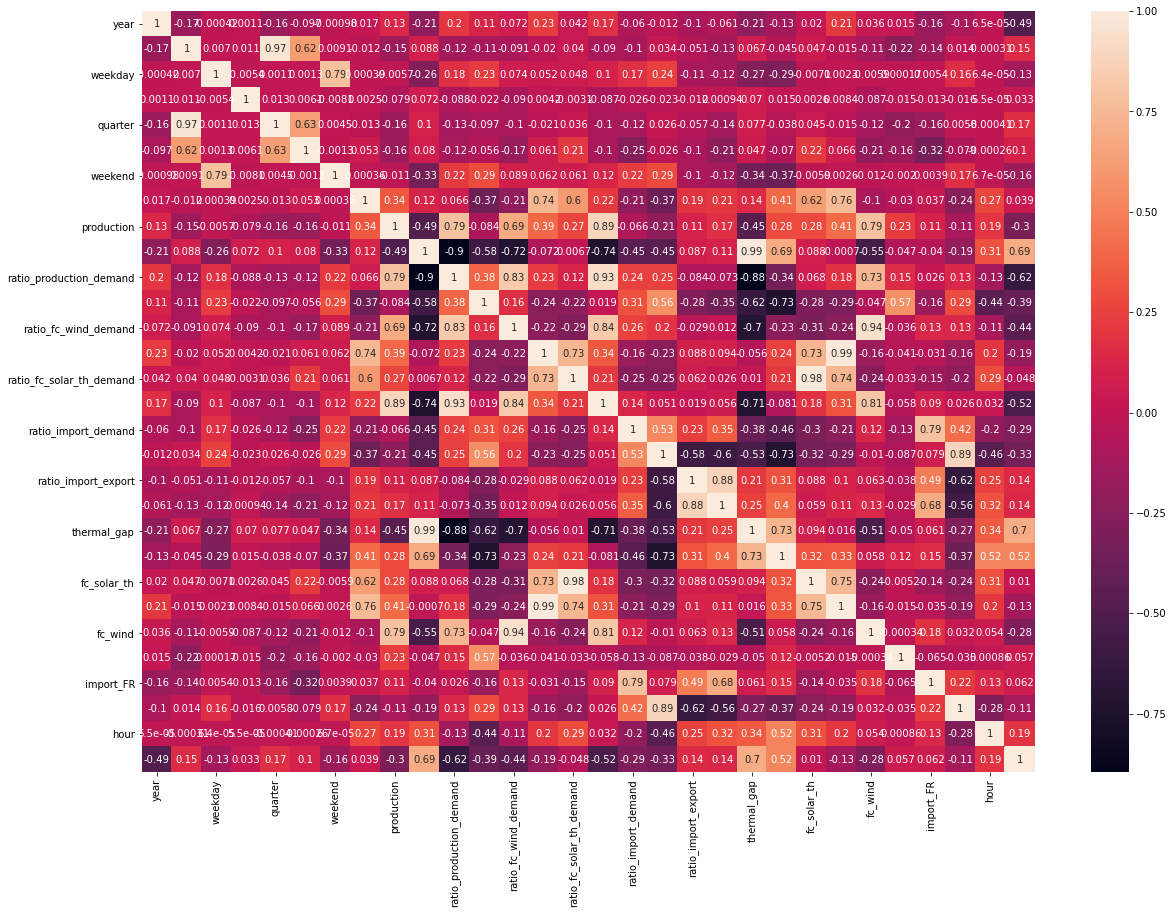

In [64]:
sns.heatmap(corr_matrix, annot=True) 
fig=plt.gcf()
fig.set_size_inches(20,14)
plt.show()

In [65]:
# train and evaluate models with all the new features
train_models(data_feat_eng, date_split)

x_train: (29183, 29)
x_test: (2952, 29)
y_train: (29183,)
y_test: (2952,)
============== Linear Regression ==================
Root Mean Squared Error: 8.344700047413086
=============== Lasso ==================
Root Mean Squared Error: 9.599574104295018
=============== Ridge ==================
Root Mean Squared Error: 8.265882620978637
=============== Elastic ==================
Root Mean Squared Error: 10.255027159915459
=============== Decision Tree ==================
Root Mean Squared Error: 10.574148757759156


We get some improvements on **ElasticNet** and **Decision Tree**. But the linear models actaully performed a little worse. May be we might need to see each features importance.

# 4. Feature Selection

**Feature selection** is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model. We might also see which features combinations are better in predicting our target variable.

We will be using tow different methods **F-test statistics and mutual information gain**

As F-test captures only linear dependency, on the other hand, mutual information can capture any kind of dependency between variables.

In [66]:
X = data_feat_eng.drop(columns=["date", "price"])
y = data_feat_eng["price"]

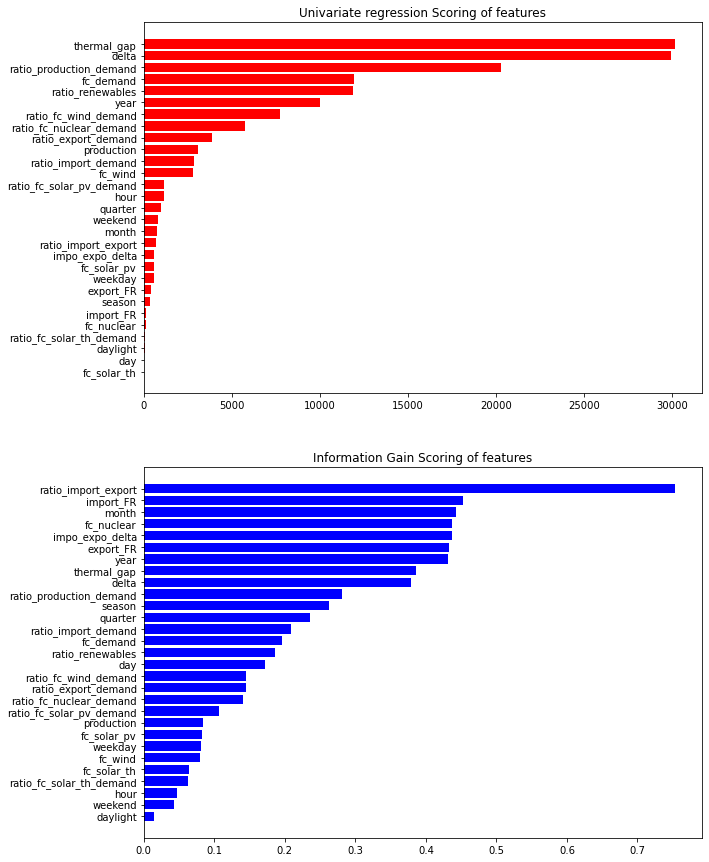

In [67]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Select K best features according to the two different methods
reg_selector = SelectKBest(score_func=f_regression).fit(X,y)  # using Univariate Linear regression
ig_selector = SelectKBest(score_func=mutual_info_regression).fit(X,y)  # using Information Gain

# Get the indices sorted by most important to least important
indices_reg = np.argsort(reg_selector.scores_)[::-1]
indices_ig = np.argsort(ig_selector.scores_)[::-1]

# Features and their score on each method
reg_features = []
for i in range(len(X.columns)):
    reg_features.append(X.columns[indices_reg[i]])
    
ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices_ig[i]])
    
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# reg scores
axes[0].invert_yaxis()
axes[0].barh(reg_features, reg_selector.scores_[indices_reg[range(len(X.columns))]], color='r', align='center')
axes[0].set_title("Univariate regression Scoring of features")

# information-gain scores
axes[1].invert_yaxis()
axes[1].barh(ig_features, ig_selector.scores_[indices_ig[range(len(X.columns))]], color='b', align='center')
axes[1].set_title("Information Gain Scoring of features")

plt.show()

In [68]:
x_train, x_test, y_train, y_test = train_test_split(data_feat_eng, date_split)

x_train: (29183, 29)
x_test: (2952, 29)
y_train: (29183,)
y_test: (2952,)


Now we will be tabulating the output of each model, with one or combination of multiple features.

# 5. Machine Leanring (Modeling)

#### Simple Models

In [69]:
linear_model = LinearRegression()
lasso_model = Lasso()
ridge_model = Ridge()
elastic_model = ElasticNet()
tree_model = DecisionTreeRegressor()

methods = {
    "reg": reg_features,
    "ig": ig_features
}

comparison = []
for name, sorted_features in methods.items():
    features_used = 0
    for i, feature in enumerate(sorted_features):

        # training on a bigger subset of features as we loop through both feature selection methods
        # as i increases, a new feature is added to the training dataset
        # since the features were sorted in descending order of score, each added feature will add less value to our prediction
        X_train_subset = x_train[sorted_features[: i+1]]
        X_test_subset = x_test[sorted_features[: i+1]]

        # train
        linear_model.fit(X_train_subset, y_train)
        lasso_model.fit(X_train_subset, y_train)
        ridge_model.fit(X_train_subset, y_train)
        elastic_model.fit(X_train_subset, y_train)
        tree_model.fit(X_train_subset, y_train)

        # predict
        linear_reg_pred = linear_model.predict(X_test_subset)
        lasso_pred = lasso_model.predict(X_test_subset)
        ridge_pred = ridge_model.predict(X_test_subset)
        elastic_pred = elastic_model.predict(X_test_subset)
        tree_pred = tree_model.predict(X_test_subset)
        
        # calculate accuracy
        linear_reg_rmse = rmse(y_test, linear_reg_pred)
        lasso_rmse = rmse(y_test, lasso_pred)
        ridge_rmse = rmse(y_test, ridge_pred)
        elastic_rmse = rmse(y_test, elastic_pred)
        tree_rmse = rmse(y_test, tree_pred)

        # increase counter to see how many features we have trained with
        features_used += 1
        dict_sorted = {
            "features": features_used,
            "linear_reg_rmse": linear_reg_rmse,
            "lasso_rmse": lasso_rmse,
            "ridge_rmse": ridge_rmse,
            "elastic_rmse": elastic_rmse,
            "tree_rmse": tree_rmse,
            "type": name
        }
        comparison.append(dict_sorted)
        
# put everything together in a dataframe
comparision_df = pd.DataFrame(comparison).pivot_table(index="features", columns="type")

In [70]:
comparision_df

elastic_rmse            lasso_rmse            linear_reg_rmse  \
type               ig        reg         ig        reg              ig   
features                                                                 
1           21.361017  15.375014  21.401890  15.375058       21.111288   
2           21.342118  15.360589  21.360375  15.360567       21.109219   
3           21.370462  15.360589  21.385911  15.360567       21.154184   
4           21.302773  15.309005  21.332663  15.309143       21.000498   
5           21.176818  15.309005  21.186744  15.309143       21.118081   
6           21.176881  11.741541  21.186871  10.717326       21.128014   
7           16.084403  11.741541  14.214829  10.717326       12.477999   
8           11.402228  11.741541  10.439859  10.717326        8.743519   
9           11.402169  11.741541  10.439841  10.717326        8.743519   
10          11.402169  11.741279  10.439841  10.716726        8.795490   
11          11.416082  11.741279  10.439841  10.716726        8.899248   
12          11.415606  11.356226  10.439841  10.404437        8.897560   
13          11.415606  11.356226  10.439841  10.404437        8.717012   
14          11.391400  11.270814  10.405432  10.346343        8.734846   
15          11.391400  11.395499  10.405432  10.443229        8.641359   
16          11.411120  11.390847  10.421957  10.443229        8.667568   
17          11.411120  11.473769  10.421957  10.567375        8.137366   
18          11.411120  11.473769  10.421957  10.567375        8.117248   
19          11.411120  11.474039  10.421957  10.567917        8.117248   
20          11.411120  10.046738  10.421957   9.330233        8.253034   
21          11.411118   9.934812  10.422043   9.260293        8.253034   
22          10.326338  10.022987   9.472310   9.387243        8.257042   
23          10.233019  10.050152   9.426323   9.387243        8.205876   
24          10.361550  10.049897   9.639373   9.387243        8.598166   
25          10.363164  10.235986   9.643915   9.582864        8.598166   
26          10.363164  10.235986   9.643915   9.582864        8.598166   
27          10.255150  10.235986   9.599733   9.582864        8.482369   
28          10.255150  10.253635   9.599733   9.595245        8.347989   
29          10.255150  10.255135   9.599733   9.599741        8.350139   

                    ridge_rmse             tree_rmse             
type            reg         ig        reg         ig        reg  
features                                                         
1         15.374970  21.111331  15.374970  21.200391  18.669813  
2         15.360610  21.109268  15.360610  22.271827  19.242101  
3         15.497563  21.154230  15.496052  25.016882  18.732220  
4         15.697307  21.000552  15.659952  25.734229  18.608210  
5         15.477656  21.118089  15.402451  26.089356  18.266464  
6          8.983757  21.118089   8.918953  26.156785   8.433966  
7          8.344543  12.495846   8.302488  14.769870   8.377284  
8          8.344543   8.743722   8.325482   9.457834   8.207089  
9          8.344495   8.743722   8.324386   9.392652   8.415442  
10         8.344495   8.795065   8.324386   9.469079   8.330905  
11         7.883767   8.898950   8.181398   9.497796   8.439111  
12         7.908115   8.897316   8.119121   9.489693   8.419529  
13         8.056826   8.634555   8.245938   9.392796   8.617597  
14         8.052897   9.031841   8.230694   8.254210   8.341558  
15         8.244335   9.028727   8.418773   9.429207  13.295071  
16         8.022807   9.057616   8.167724  10.468318  13.195035  
17         8.200392   8.425040   8.324664   9.633450  11.700108  
18         8.201637   8.421906   8.325475  10.762610  10.670899  
19         8.201637   8.487889   8.325475  10.386970  10.459781  
20         8.000617   8.560198   8.276981  10.057442  10.561865  
21         7.996491   8.560198   8.273551  11.334850  10.181800  
22         7.943790   8.459600   8.189994  10.746962  10

In [71]:
comparision_df.apply(["min"])

elastic_rmse           lasso_rmse           linear_reg_rmse            \
              ig       reg         ig       reg              ig       reg   
min    10.233019  9.934812   9.426323  9.260293        8.117248  7.883767   

    ridge_rmse           tree_rmse            
            ig       reg        ig       reg  
min   8.265883  8.119121   8.25421  8.207089

We have better scores than before at different features.

* **Decision Tree** - best score with 9 features.
* **Linear Regression** - best score with 22 features.

May be we can improve our models better that this with more complex models

#### Complex Models.

In [72]:
random_forest_model = RandomForestRegressor(random_state=random_state)
extra_tree_model = ExtraTreeRegressor()
lgbm_model = LGBMRegressor()
xgboost_model = XGBRegressor(objective="reg:squarederror")

methods = {
    "reg": reg_features,
    "ig": ig_features
}

comparison = []
for name, sorted_features in methods.items():
    features_used = 0
    for i, feature in enumerate(sorted_features):

        # training on a bigger subset of features as we loop through both feature selection methods
        # as i increases, a new feature is added to the training dataset
        # since the features were sorted in descending order of score, each added feature will add less value to our prediction
        X_train_subset = x_train[sorted_features[: i+1]]
        X_test_subset = x_test[sorted_features[: i+1]]

        # train
        random_forest_model.fit(X_train_subset, y_train)
        extra_tree_model.fit(X_train_subset, y_train)
        lgbm_model.fit(X_train_subset, y_train)
        xgboost_model.fit(X_train_subset, y_train)

        # predict
        random_forest_pred = random_forest_model.predict(X_test_subset)
        extra_tree_pred = extra_tree_model.predict(X_test_subset)
        lgbm_pred = lgbm_model.predict(X_test_subset)
        xgboost_pred = xgboost_model.predict(X_test_subset)
        
        # calculate accuracy
        random_forest_rmse = rmse(y_test, random_forest_pred)
        extra_tree_rmse = rmse(y_test, extra_tree_pred)
        lgbm_rmse = rmse(y_test, lgbm_pred)
        xgboost_rmse = rmse(y_test, xgboost_pred)


        # increase counter to see how many features we have trained with
        features_used += 1
        dict_sorted = {
            "features": features_used,
            "random_forest_rmse": random_forest_rmse,
            "extra_tree_rmse": extra_tree_rmse,
            "lgbm_rmse": lgbm_rmse,
            "xgboost_rmse": xgboost_rmse,
            "type": name
        }
        comparison.append(dict_sorted)
        
# put everything together in a dataframe
comparision_df = pd.DataFrame(comparison).pivot_table(index="features", columns="type")

In [73]:
comparision_df

extra_tree_rmse             lgbm_rmse            random_forest_rmse  \
type                  ig        reg         ig        reg                 ig   
features                                                                       
1              21.224721  18.653138  19.768929  15.882666          21.123131   
2              23.502693  18.940047  22.337781  15.692965          22.020160   
3              26.149350  18.639100  24.943445  15.284628          25.472013   
4              29.782606  18.498458  23.554058  15.294269          25.256868   
5              25.499069  18.377807  24.680365  15.062808          25.048464   
6              25.564750   8.826044  25.756355   5.723823          26.171202   
7              14.567768   8.833875  14.795645   5.618632          14.469149   
8               9.991135   8.660601   8.750274   6.635101           9.145167   
9               9.571458   8.819470   8.988736   5.845586           9.146834   
10             10.035860   8.207244   8.743201   5.841753           9.263198   
11              9.388716   8.032417   8.535361   5.776398           9.234451   
12              9.658182   9.736166   8.535361   5.681711           9.263459   
13              9.737270   8.354589   8.353954   6.084976           9.097605   
14             10.284190   8.576248   8.335084   5.554902           8.382699   
15              9.655146  13.958502   8.390778   9.845455           8.673627   
16             10.463293  13.630579   8.383159   9.792809           9.528327   
17             13.220612  13.396972   8.718053   9.880458           9.544607   
18             11.964047  13.247502   8.616456   9.230098           9.930271   
19             10.494085  12.521981   8.697168   9.015175           9.931268   
20             10.126875  11.293201   8.699470   9.072441          10.033038   
21             11.617875  13.246189   8.561724   9.183429          10.059760   
22             14.275153  12.892924   8.374782   8.615594          10.182951   
23             10.960145  10.674261   8.188533   8.815429          10.106711   
24             10.257666  12.352447   8.331191   8.948041          10.198563   
25             10.375492  11.530573   8.551688   8.370924          10.091381   
26              9.954080  11.180988   8.602607   8.112255          10.002635   
27             12.470377  10.207191   8.156162   8.207559          10.050218   
28             10.533510  11.847287   8.156162   8.694762          10.146329   
29             10.711549  10.304483   8.307066   8.288509          10.129956   

                    xgboost_rmse             
type            reg           ig        reg  
features                                     
1         17.183869    20.778325  15.971933  
2         17.126486    22.494747  15.795954  
3         15.927111    26.403789  15.467596  
4         15.777416    24.162865  15.382386  
5         15.202337    24.413857  15.042587  
6          6.312537    25.113263   7.887734  
7          6.103313    13.604661   7.503753  
8          6.553995    10.275708   6.978223  
9          5.913618     9.916048   6.282612  
10         5.922278     9.699234   6.753696  
11         6.503787     9.576754   6.912000  
12         6.561269     9.576754   7.061584  
13         6.536098     9.818833   6.909159  
14         6.277870     9.310445   6.816667  
15        11.481119     9.323377  12.117772  
16        11.567921     9.683620  12.364553  
17        11.775367     9.563911  12.779885  
18        10.999698    10.024890  11.709991  
19        11.037475    10.389694  11.264222  
20        11.106807    10.431997  11.079502  
21        11.191380    10.077083  10.544395  
22        10.793757    10.256605  10.597684  
23        10.865359    10.030306  10.910783  
24        11.030005     9.946475  10.799022  
25         9.714834    10.360529   9.134666  
26         9.662516    10.202422   9.308486  
27         9.617547     9.695106   9.437564  
28        10.043149     9.695106  10.313674  
29        10.085336   

In [74]:
comparision_df.apply(["min"])

extra_tree_rmse           lgbm_rmse           random_forest_rmse  \
                 ig       reg        ig       reg                 ig   
min        9.388716  8.032417  8.156162  5.554902           8.382699   

              xgboost_rmse            
          reg           ig       reg  
min  5.913618     9.310445  6.282612

Impressive. We have much lower score with **LightGBM**. **Random Forest and XGBosst** are also giving some comparable results.

Now since we are dealing with time series data, we wanted to see how our models perform with time series split cross validation. We'll start with the simpler models first.

In [91]:
tscv = TimeSeriesSplit(n_splits=10)

def cv_rmse(model, train_data, target):
    rmse = cross_val_score(model, train_data, target, scoring="neg_root_mean_squared_error", cv=tscv)
    return rmse

In [92]:
ridge = make_pipeline(RobustScaler(), Ridge())
lasso = make_pipeline(RobustScaler(), Lasso())
elasticnet = make_pipeline(RobustScaler(), ElasticNet())

In [93]:
score = cv_rmse(lasso, X, y)
print("Lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet, X, y)
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(ridge, X, y)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso: -11.2293 (3.7623)

Elastic net: -11.5171 (4.1709)

Ridge: -14.1769 (3.8524)



We have added the scaling parameter to our pipeline to see the effect of normalizing our features. But it seems we still have a good score. May be adding polynomial degree might help. 

In [96]:
ridge = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), Ridge())
lasso = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), Lasso())
elasticnet = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), ElasticNet())

In [97]:
score = cv_rmse(lasso, X, y)
print("Lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet, X, y)
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(ridge, X, y)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso: -13.0680 (7.1644)

Elastic net: -14.0870 (8.7785)

Ridge: -20.5269 (10.2981)



Interesting, Polynomial Degree doesn't help at all. We think we are better off with **LightGBM**. We can use **RandomSearchCV** to find the best parameters.

In [101]:
tscv = TimeSeriesSplit(n_splits=5)

# Maximum number of leaves
num_leaves = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Maximum depth of each trained tree
max_depth = [10, 20, 30, 40, 50, 100, 200, 300, 400, -1]

# Number of trees 
num_iterations= [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Method of selecting samples for training each tree
learning_rate = [0.0001, 0.001, 0.01, 0.1]

# Create the random grid
random_grid = {'num_leaves': num_leaves,
               'num_iterations': num_iterations,
               'learning_rate': learning_rate,
               'max_depth': max_depth}
print(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm = LGBMRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = random_grid, n_iter = 100, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(X, y)

{'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'num_iterations': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'learning_rate': [0.0001, 0.001, 0.01, 0.1], 'max_depth': [10, 20, 30, 40, 50, 100, 200, 300, 400, -1]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 72.6min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1],
  

In [103]:
lgbm_random.best_params_

{'learning_rate': 0.1,
 'max_depth': 100,
 'num_iterations': 2000,
 'num_leaves': 10}

In [121]:
lgbm_model = LGBMRegressor(learning_rate = 0.1,
                           max_depth = 100,
                           num_iterations = 2000,
                           num_leaves = 10)

In [107]:
score = cv_rmse(lgbm_model, X, y)
print("LightGBM : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LightGBM : -12.1150 (3.3629)



In [77]:
 # splitting data for validation.
split_date = pd.to_datetime("2020-05-01")
# training vs target
X = data_feat_eng.drop(columns=["price"])
y = data_feat_eng[["date", "price"]]

X_train = X[X["date"] < split_date].drop(["date"], axis=1)
X_test = X[X["date"] >= split_date].drop(["date"], axis=1)
y_train = y[y["date"] < split_date].drop("date", axis=1).values.ravel()
y_test = y[y["date"] >= split_date].drop("date", axis=1).values.ravel()

In [78]:
# Train.
lgbm_model.fit(X_train, y_train)

# Predict
lgbm_pred = lgbm_model.predict(X_test)

# Evaluate
score = rmse(y_test, lgbm_pred)
print("Final RMSE Score: {}".format(score))

Final RMSE Score: 8.281952374096313


It's a good score. Earlier we found that LightGBM performs best with around 7 features. Let's test that hypothesis.

In [79]:
X_train_feat_sel = X_train[reg_features[:7]]
X_test_feat_sel = X_test[reg_features[:7]]

In [80]:
# Train.
lgbm_model.fit(X_train_feat_sel, y_train)

# Predict
lgbm_feat_sel_pred = lgbm_model.predict(X_test_feat_sel)

# Evaluate
score = rmse(y_test, lgbm_feat_sel_pred)
print("Selected Feature RMSE Score: {}".format(score))

Selected Feature RMSE Score: 5.6186322182773925


Interestingly, our model was slightly better but worse compared to the model with default parameters of LightGBM. May be we're overfitting. So we have decided to go with the default parameters and predict on our test data with selected features.

In [81]:
# LightGBM with default parameters.
lgbm = LGBMRegressor()
lgbm.fit(X_train_feat_sel, y_train)

# Predict
lgbm_feat_sel_pred = lgbm.predict(X_test_feat_sel)

# Evaluate
score = rmse(y_test, lgbm_feat_sel_pred)
print("Selected Feature RMSE Score: {}".format(score))

Selected Feature RMSE Score: 5.6186322182773925


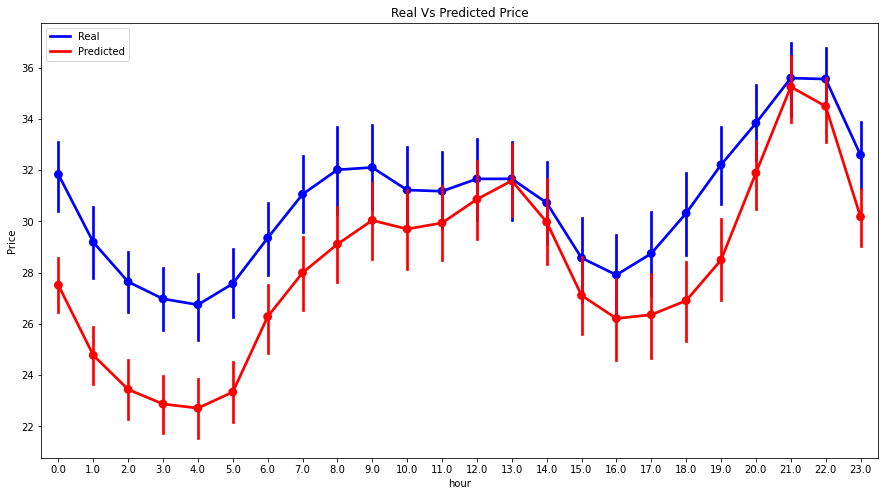

In [82]:
# Plot Real Vs Predicted
hour=X_test.hour

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig = sns.pointplot(ax=ax, x=hour, y=y_test, color='blue')
fig = sns.pointplot(ax=ax, x=hour, y=lgbm_feat_sel_pred, color='red')
fig.set_ylabel("Price")

ax.legend(labels=["Real", "Predicted"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
ax.set_title("Real Vs Predicted Price")

plt.show()

Our model, seem to forecast a close **price** range to the real one. 

We are finally here. Let's predict the price on the test data.

# 6. Prediction

As we mentioned before, we have prepared a pipeline including transformations and feature engineering.
Let's apply our pipeline and predict the **Price**

In [ ]:
test = pd.read_csv("scoring.csv", parse_dates=["date"])

In [155]:
test.head()

fc_demand  fc_nuclear  import_FR  ...       date  hour      price
0    24744.0      7117.2     2300.0  ... 2020-09-01     0  31.615819
1    23426.0      7117.2     2300.0  ... 2020-09-01     1  27.197101
2    22597.0      7117.2     2300.0  ... 2020-09-01     2  26.177437
3    22285.0      7117.2     2300.0  ... 2020-09-01     3  27.083926
4    22192.0      7117.2     2300.0  ... 2020-09-01     4  25.649199

[5 rows x 10 columns]

In [156]:
test_preprocessed = preprocessing.fit_transform(test)

In [157]:
columns = ["year", "month", "weekday", "day", "quarter", "season", "weekend", "daylight",
           "production", "delta", "ratio_production_demand", "ratio_fc_nuclear_demand", "ratio_fc_wind_demand", 
           "ratio_fc_solar_pv_demand", "ratio_fc_solar_th_demand", "ratio_renewables", "ratio_import_demand", 
           "ratio_export_demand", "ratio_import_export", "impo_expo_delta", "thermal_gap","fc_demand", 
           "fc_solar_th", "fc_solar_pv", "fc_wind", "fc_nuclear", "import_FR", "export_FR", "hour"]

test_data = pd.DataFrame(test_preprocessed, columns = columns)

In [158]:
test_data.head()

year  month  weekday  day  ...  fc_nuclear  import_FR  export_FR  hour
0  2020.0    9.0      1.0  1.0  ...      7117.2     2300.0     1750.0   0.0
1  2020.0    9.0      1.0  1.0  ...      7117.2     2300.0     2100.0   1.0
2  2020.0    9.0      1.0  1.0  ...      7117.2     2300.0     2100.0   2.0
3  2020.0    9.0      1.0  1.0  ...      7117.2     2300.0     2100.0   3.0
4  2020.0    9.0      1.0  1.0  ...      7117.2     2300.0     2100.0   4.0

[5 rows x 29 columns]

In [159]:
test_data.isna().sum()

year                        0
month                       0
weekday                     0
day                         0
quarter                     0
season                      0
weekend                     0
daylight                    0
production                  0
delta                       0
ratio_production_demand     0
ratio_fc_nuclear_demand     0
ratio_fc_wind_demand        0
ratio_fc_solar_pv_demand    0
ratio_fc_solar_th_demand    0
ratio_renewables            0
ratio_import_demand         0
ratio_export_demand         0
ratio_import_export         0
impo_expo_delta             0
thermal_gap                 0
fc_demand                   0
fc_solar_th                 0
fc_solar_pv                 0
fc_wind                     0
fc_nuclear                  0
import_FR                   0
export_FR                   0
hour                        0
dtype: int64

In [160]:
# making prediction with top features.
top_features = reg_features[:7]
test_pred = lgbm.predict(test_data[best_features])

In [161]:
submission = pd.DataFrame()
submission = test
submission["price"] = test_pred

In [162]:
submission.to_csv("prediction.csv", index=False)